In [ ]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import theano

from scipy import stats
from sklearn.metrics import mean_squared_error
import math

import matplotlib.pyplot as plt
import arviz as az

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
d = pd.read_csv('data/foxes.csv', sep=';', header=0)
d.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


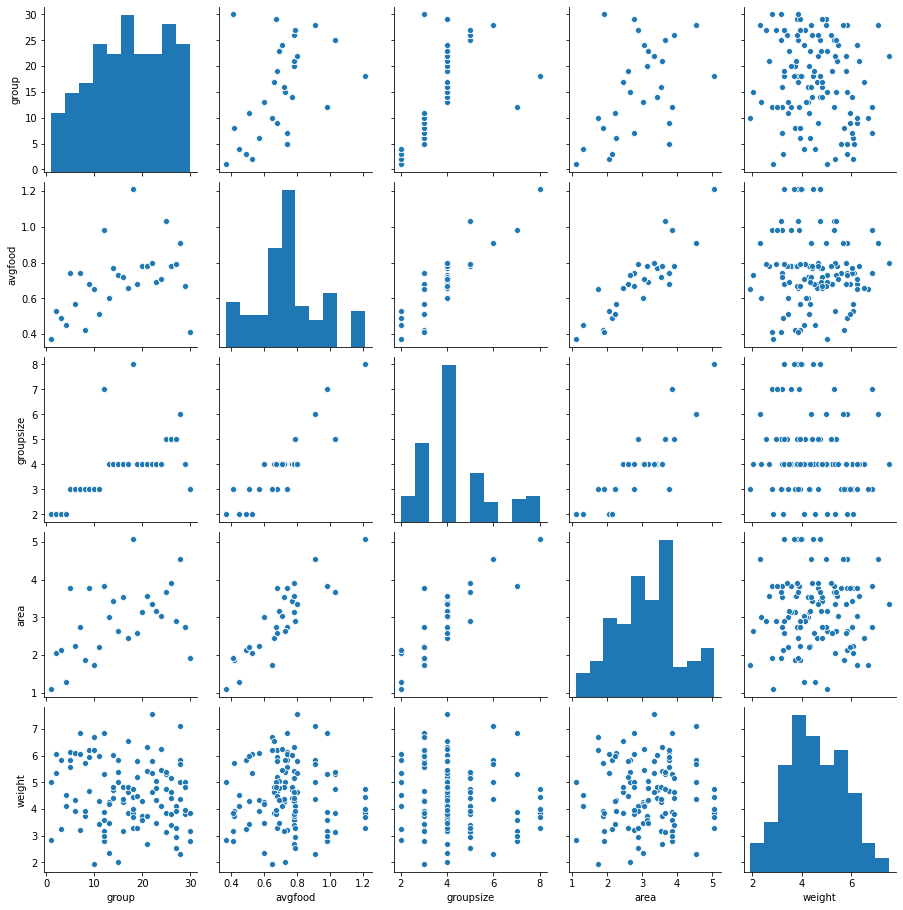

In [ ]:
sns.pairplot(d)

In [ ]:
d.dtypes

group          int64
avgfood      float64
groupsize      int64
area         float64
weight       float64
dtype: object

In [ ]:
d.describe()

,group,avgfood,groupsize,area,weight
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,17.206897,0.751724,4.344828,3.169138,4.529655
std,8.002736,0.198316,1.538511,0.928354,1.184023
min,1.000000,0.370000,2.000000,1.090000,1.920000
25%,11.750000,0.660000,3.000000,2.590000,3.720000
50%,18.000000,0.735000,4.000000,3.130000,4.420000
75%,24.000000,0.800000,5.000000,3.772500,5.375000
max,30.000000,1.210000,8.000000,5.070000,7.550000


### Excercise 1

In [ ]:
# with pm.Model() as model_ex1:
#     area = pm.Data('area', d.area.to_numpy())
#     avgfood = pm.Data('avgfood', d.avgfood.to_numpy())
#     groupsize = pm.Data('groupsize', d.groupsize.to_numpy())
#     weight = pm.Data('weight', d.weight.to_numpy())
    
#     β_area = pm.Normal("β_area", mu=0, sd=5)    
#     α_food = pm.Normal("α_food", mu=1, sd=1)
#     β_food = pm.Normal("β_food", mu= α_food + β_area * area, sd=1, observed=avgfood)
    
#     σ_weight = pm.Uniform("σ_weight", lower=0, upper=10)
#     μ = groupsize + β_food * avgfood
#     y_weight = pm.Normal('y_weight', mu=μ, sd=σ_weight, observed=weight)
    
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(draws=1000, tune=1000)
#     posterior = pm.sample_posterior_predictive(trace)

In [ ]:
from sklearn import preprocessing
d[['avgfood','groupsize','area','weight']] = preprocessing.scale(d[['avgfood','groupsize','area','weight']])
d.head()

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973


In [ ]:
with pm.Model() as model_1:
    # Data
    area = pm.Data('area', d['area'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * area
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 100)
    posterior_1 = pm.sample()
    posterior_pred_1 = pm.sample_posterior_predictive(posterior_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
az.summary(posterior_1, credible_interval=.89).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.00,0.09,-0.17,0.16,0.0,0.0,4833.0,1997.0,4828.0,3102.0,1.0
beta,0.02,0.09,-0.17,0.19,0.0,0.0,4762.0,2032.0,4770.0,2756.0,1.0
sigma,1.02,0.07,0.90,1.16,0.0,0.0,4483.0,4455.0,4524.0,2905.0,1.0


[]

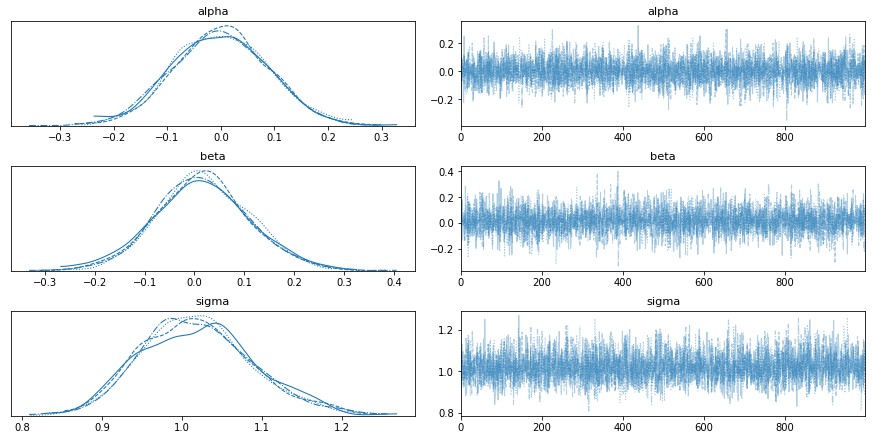

In [ ]:
pm.traceplot(posterior_1)
plt.plot()

##### Sample the priors

In [ ]:
df = pd.DataFrame()
df = df.assign(alpha = pd.Series(prior['alpha']),
               sigma = pd.Series(prior['sigma']),
               beta = pd.Series(prior['beta']))
df.shape

(100, 3)

In [ ]:
df.head()

,alpha,sigma,beta
0,-0.320534,1.052369,0.378236
1,0.059588,0.285118,-0.834016
2,-0.269354,0.998954,0.989288
3,-0.134025,0.087901,-0.793461
4,0.004959,1.742548,0.078082


In [ ]:
priors = pd.DataFrame()
for i in range(df.shape[0]):
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i, 'beta'] * d['area']

In [ ]:
priors.shape

(116, 100)

In [ ]:
aux = pd.concat([d.area, priors], axis=1)
aux.head()

,area,prior_0,prior_1,prior_2,prior_3,prior_4,prior_5,prior_6,prior_7,prior_8,...,prior_90,prior_91,prior_92,prior_93,prior_94,prior_95,prior_96,prior_97,prior_98,prior_99
0,-2.249313,-1.171305,1.935552,-2.494572,1.650716,-0.170671,0.657878,-0.412583,0.222059,0.947986,...,-1.402163,-0.362204,1.058893,0.321829,-0.472378,1.007413,-0.537329,-1.834930,0.176752,1.628395
1,-2.249313,-1.171305,1.935552,-2.494572,1.650716,-0.170671,0.657878,-0.412583,0.222059,0.947986,...,-1.402163,-0.362204,1.058893,0.321829,-0.472378,1.007413,-0.537329,-1.834930,0.176752,1.628395
2,-1.210738,-0.778479,1.069363,-1.467122,0.826648,-0.089577,0.349970,-0.275100,0.132107,0.592201,...,-0.658661,-0.172377,0.561378,0.055927,-0.296601,0.626412,-0.290833,-0.893375,0.124155,0.782306
3,-1.210738,-0.778479,1.069363,-1.467122,0.826648,-0.089577,0.349970,-0.275100,0.132107,0.592201,...,-0.658661,-0.172377,0.561378,0.055927,-0.296601,0.626412,-0.290833,-0.893375,0.124155,0.782306
4,-1.135008,-0.749835,1.006204,-1.392204,0.766559,-0.083664,0.327518,-0.265075,0.125548,0.566259,...,-0.604447,-0.158535,0.525101,0.036538,-0.283784,0.598630,-0.272859,-0.824720,0.120320,0.720612


In [ ]:
aux_plot = aux.melt(id_vars=['area'], value_vars=list(aux.columns)[1:],
                    var_name='prior', value_name='weight')
aux_plot.shape

(11600, 3)

In [ ]:
aux_plot

,area,prior,weight
0,-2.249313,prior_0,-1.171305
1,-2.249313,prior_0,-1.171305
2,-1.210738,prior_0,-0.778479
3,-1.210738,prior_0,-0.778479
4,-1.135008,prior_0,-0.749835
...,...,...,...
11595,-0.453444,prior_99,0.165366
11596,-0.453444,prior_99,0.165366
11597,-1.362197,prior_99,0.905694
11598,-1.362197,prior_99,0.905694


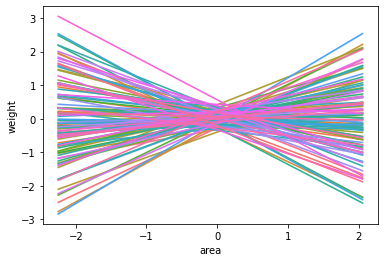

In [ ]:
sns.lineplot(x='area', y='weight', data=aux_plot, hue='prior', legend=False)

### Excercise 2

In [ ]:
with pm.Model() as model_2:
    # Data
    avgfood = pm.Data('avgfood', d['avgfood'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta = pm.Normal('beta', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta * avgfood
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior = pm.sample_prior_predictive(samples = 100)
    trace_2 = pm.sample()
    posterior_2 = pm.sample_posterior_predictive(trace_2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


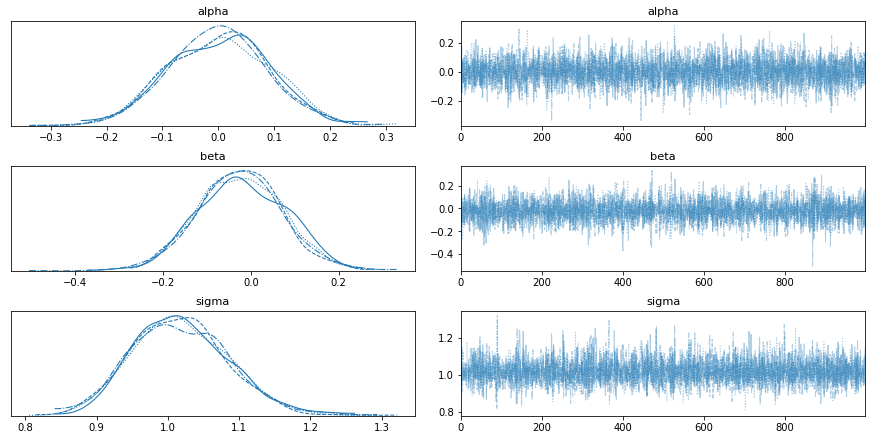

In [ ]:
pm.traceplot(trace_2)
plt.show()

In [ ]:
az.summary(trace_2, credible_interval=0.89)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.089,-0.152,0.174,0.001,0.001,4632.0,1966.0,4622.0,2720.0,1.0
beta,-0.023,0.096,-0.205,0.149,0.001,0.002,5311.0,1598.0,5285.0,2397.0,1.0
sigma,1.018,0.067,0.891,1.139,0.001,0.001,4906.0,4851.0,4936.0,2555.0,1.0


### Excercise 3

In [ ]:
with pm.Model() as model_3:
    # Data
    avgfood = pm.Data('avgfood', d['avgfood'].values)
    groupsize = pm.Data('groupsize', d['groupsize'].values)
    weight = pm.Data('weight', d['weight'].values)
    
    # Priors
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta_food = pm.Normal('beta_food', mu=0, sd=0.5)
    beta_gsize = pm.Normal('beta_gsize', mu=0, sd=0.5)
    sigma = pm.Uniform('sigma', lower=0, upper=2)
    
    # Regression
    mu = alpha + beta_food * avgfood + beta_gsize * groupsize
    weight_hat = pm.Normal('weight_hat', mu=mu, sd=sigma, observed=weight)
    
    # Prior sampling, trace definition and posterior sampling
    prior3 = pm.sample_prior_predictive(samples = 100)
    trace_3 = pm.sample()
    posterior_3 = pm.sample_posterior_predictive(trace_3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_gsize, beta_food, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [ ]:
az.summary(trace_3, credible_interval=0.89)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.002,0.080,-0.156,0.145,0.001,0.001,3436.0,1557.0,3439.0,2467.0,1.0
beta_food,0.471,0.187,0.117,0.816,0.004,0.003,2226.0,2125.0,2237.0,1913.0,1.0
beta_gsize,-0.567,0.187,-0.918,-0.215,0.004,0.003,2238.0,2178.0,2248.0,2239.0,1.0
sigma,0.971,0.068,0.855,1.109,0.001,0.001,3080.0,3080.0,3022.0,1878.0,1.0


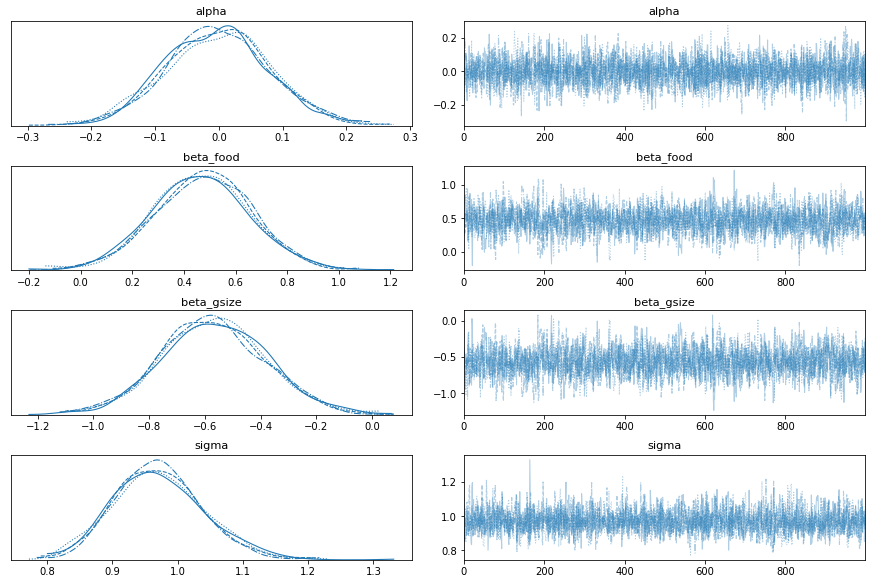

In [ ]:
pm.traceplot(trace_3)
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f59a3faa610>],
      dtype=object)

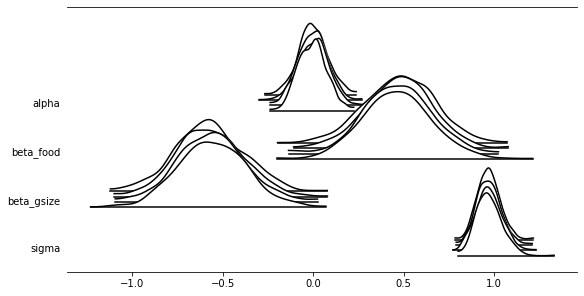

In [ ]:
az.plot_forest(trace_3, kind='ridgeplot', colors='white', figsize=(8,4))

## Comparison

In [ ]:
pm.compare({"model 1": posterior_1, "model 2": trace_2, "model 3": trace_3}, ic="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model 3,0,-162.295,3.43498,0,0.883462,6.58935,0,False,log
model 2,1,-167.225,2.33723,4.92993,0.0568546,6.63801,3.08587,False,log
model 1,2,-167.343,2.52876,5.04765,0.0596831,7.56329,3.18779,False,log
